## Análise para recuperação I/Q utilizando modelos convolucionais

- Este notebook explora a implementação da rede citada no artigo "[Deep learning-based Phase Retrieval Scheme for Minimum-phase Signal Recovery](https://ieeexplore.ieee.org/document/9911725)" e tem como objetivo estudar o seu comportamento para variações de *Roll-off* e deslocamentos de frequência.

In [2]:
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1DTranspose, Conv1D, Flatten, Add, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model

## Define o Modelo da Rede Neural.

In [3]:
def create_convnet(N, n0, img_path='convnet_image.png'):
    
    """ Esta função retorna o modelo da rede neural citada pelo artigo 
    "Deep learning-based Phase Retrieval Scheme for Minimum-phase Signal Recovery".
    Alguns parâmetros podem ser fixos como:
    
    k = 3: tamanho do kernel das camadas convolucionais 1D dentro de um Bloco D/U
    s: passo das camadas convolucionais 1D dentro de um bloco D/U, para este caso foi selecionado s = 2.
    d: profundidade do modelo, ou seja, o número de blocos D e U, para este caso foi selecionado d = 3
        
    Args:
        N (int): Número de amostras de amplitude do sinal.
        n0 (int): Número de núcleos de camadas convolucionais 1D dentro de um bloco D/U
        img_path (str, optional): Nome do arquivo de saída para o plot do modelo em .png. Defaults to 'convnet_image.png'.

    Returns:
        object: modelo da rede neural.
    """
    
    model = Sequential()   
    input_shape = tf.keras.Input(shape=(N, 1))
    
    normalize = BatchNormalization()(input_shape)
    relu_layer = Activation('relu')(normalize)

    # skip connection
    skipConnection0 = Conv1D(filters=n0, kernel_size=1, activation='linear')(relu_layer)
    
    ## D Block 01
    Dtower_7 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(relu_layer)
    # parallel layer
    Dtower_parallel_01 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(relu_layer)
    Dtower_8 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(Dtower_7)
    D01_added = Add()([Dtower_8, Dtower_parallel_01])
     
    # skip connection
    skipConnection1 = Conv1D(filters=n0, kernel_size=1, activation='linear')(D01_added)
    
    ## D Block 02
    Dtower_5 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D01_added)
    # parallel layer
    Dtower_parallel_02 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D01_added)  
    Dtower_6 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(Dtower_5)
    D02_added = Add()([Dtower_6, Dtower_parallel_02])
    
    # skip connection
    skipConnection2 = Conv1D(filters=n0, kernel_size=1, activation='linear')(D02_added)
    
    ## D Block 03
    Dtower_3 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D02_added)
    # parallel layer
    Dtower_parallel_03 = Conv1D(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D02_added)  
    Dtower_4 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(Dtower_3)
    D03_added = Add()([Dtower_4, Dtower_parallel_03])

    ## U Block 03 
    tower_1 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D03_added)
    # parallel layer
    tower_parallel_03 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(D03_added)
    tower_2 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(tower_1)
    U01_added = Add()([tower_2, tower_parallel_03, skipConnection2])

    ## U Block 02
    tower_3 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U01_added)
    # parallel layer
    tower_parallel_02 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U01_added) 
    tower_4 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(tower_3)
    U02_added = Add()([tower_4, tower_parallel_02, skipConnection1])
    
    ## U Block 01
    tower_5 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U02_added)
    # parallel layer
    tower_parallel_01 = Conv1DTranspose(n0, kernel_size=3, padding='same', strides=2, activation='relu')(U02_added)  
    tower_6 = Conv1D(n0, kernel_size=3, padding='same', activation='relu')(tower_5)
    U03_added = Add()([tower_6, tower_parallel_01, skipConnection0])
    
    # output layer
    output_layer = Conv1D(2, kernel_size=3, padding='same', activation='linear')(U03_added)
    flat = Flatten()(output_layer)
    output = Dense(2, activation='linear')(flat)
    
    model = tf.keras.Model(input_shape, output)
    plot_model(model, to_file=img_path, show_layer_names=True, show_layer_activations=True)
    
    return model

In [83]:
model = create_convnet(128, 32)
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 batch_normalization_51 (BatchN  (None, 128, 1)      4           ['input_52[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_51 (Activation)     (None, 128, 1)       0           ['batch_normalization_51[0][0]'] 
                                         

### Simulation of a single polarization optical signal transmission

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, linFiberCh, KramersKronigRx, photodiode

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const
from tqdm.notebook import tqdm

In [5]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 0       # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs

### Core simulation code

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB


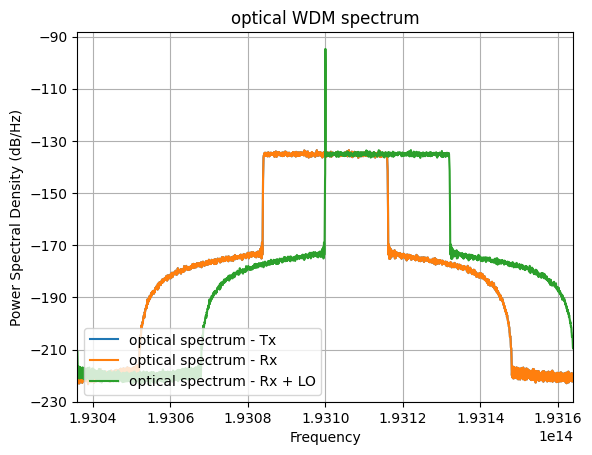

In [6]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# plots optical spectrum before and after transmission

# before
plt.figure()
plt.xlim(paramTx.Fc - Fs / 2, paramTx.Fc + Fs / 2)
plt.psd(
    sigTx[:, 0],
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Tx",
)

# after
plt.psd(
    sigCh,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx",
)
plt.legend(loc="lower left")
plt.title("optical spectrum")

# receiver detection and demodulation

Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# plot spectrum fter adding LO
plt.psd(
    sigRx,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx + LO",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

### Phase-retrieval stage

SIR =  25.69  dB


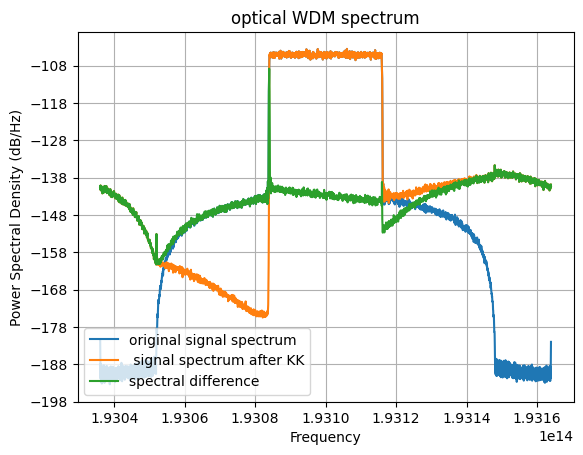

In [7]:
# simulate ideal direct-detection optical receiver
Ipd = photodiode(sigRx, paramPD)
Amp = np.sqrt(Ipd)
Amp = resample(Amp, paramADC)

# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

# Kramers-Kronig phase-retrieval
phiTime = KramersKronigRx(Amp, newFs)

# optical field reconstruction
sigRx = Amp*np.exp(1j*phiTime)
sfm_KK = sigRx.copy()

# remove DC level
sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after KK",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

# calculate interference
intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR),2), ' dB')

#### Standard receiver processing

In [ ]:
# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)

: 

In [8]:
# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard, :], lim=True)

NameError: name 'symbRx' is not defined

In [ ]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 75
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)

: 

#### Evaluate transmission metrics

In [15]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
MI = monteCarloMI(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]));

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 28.14 dB
MI: 4.00 bits
GMI: 4.00 bits


### Neural network training 

In [ ]:
N = 128 # number of input amplitude samples to the NN
n0 = 32 # number of cores of 1D convolutional layers within a D/U block
batch_size = 256 # Lot size

sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

# create set of input features
X_train = np.zeros((len(sigPhase), N)) #(L,N)

for indPhase in range(len(sigPhase)):
    X_train[indPhase] = sigAmp[indPhase:N+indPhase]

# create set of phase labels
y_train = np.array([sfm.real, sfm.imag]).T

# define neural network model
stop = EarlyStopping(monitor='val_loss', patience=5)
model = create_convnet(N, n0)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=batch_size)
model.summary()

model.save('ConvNets_models/convnet_model_SpS_'+str(paramTx.SpS), save_format='h5')

In [12]:
#model = tf.keras.models.load_model(r'C:\Users\optic\Documents\PIVIC-PIBIC-Comunicacoes-Opticas\jupyter notebooks\ConvNets_models\convnet_model_SpS_4')
sfm_NN = model.predict(X_train)

12500/12500 [==============================] - 53s 4ms/step


C:\Users\optic\AppData\Local\Temp\ipykernel_5932\2632733575.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-x" (-> color='k'). The keyword argument will take precedence.
  plt.plot(np.real(sfm)[300:400],'k-x',color='black', label='True - Real')


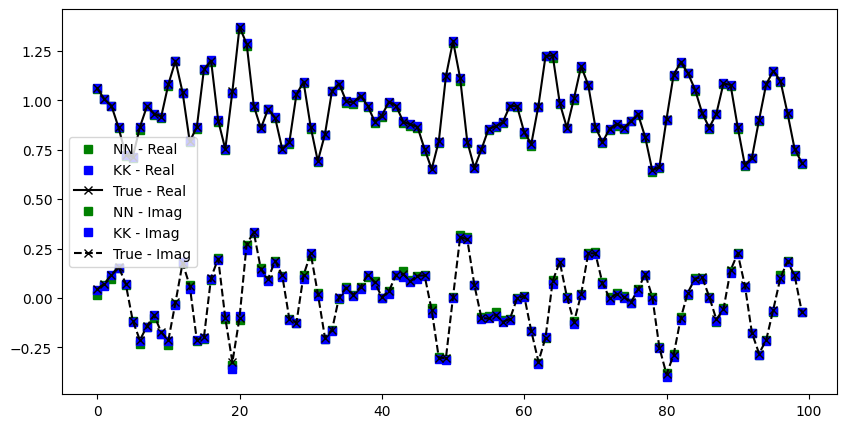

In [47]:
sfm_KK = sfm_KK/np.sqrt(signal_power(sfm_KK))

plt.figure(figsize=(10,5))
plt.plot(sfm_NN[300:400,0],'s',color='g',label='NN - Real')
plt.plot(np.real(sfm_KK)[300:400],'s',color='b',label='KK - Real')
plt.plot(np.real(sfm)[300:400],'k-x',color='black', label='True - Real')

plt.plot(sfm_NN[300:400,1],'s',color='g',label='NN - Imag')
plt.plot(np.imag(sfm_KK)[300:400],'s',color='b',label='KK - Imag')
plt.plot(np.imag(sfm)[300:400],'k--x',label='True - Imag')

plt.legend();

  0%|          | 0/1 [00:00<?, ?it/s]

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
CSPR = 12.00 dB
12500/12500 [==============================] - 50s 4ms/step
SIR =  22.87  dB


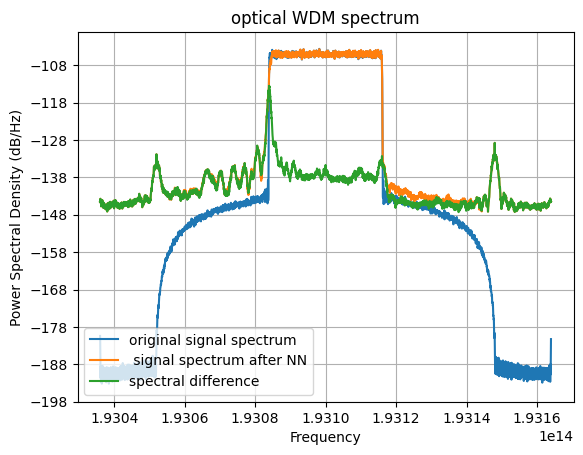

In [19]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# receiver detection and demodulation
Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# simulate ideal direct-detection optical receiver
Ipd = photodiode(sigRx, paramPD)
Amp = np.sqrt(Ipd)
Amp = resample(Amp, paramADC)

# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

sfm = sfm/np.sqrt(signal_power(sfm))

sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
sigAmp   = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

# create set of input features
X_input = np.zeros((len(sigPhase), N)) #(L,N)

for indPhase in range(len(sigPhase)):
    X_input[indPhase] = sigAmp[indPhase:N+indPhase]

sigRx_NN = model.predict(X_input)
# optical field reconstruction
sigRx = sigRx_NN[:,0]+1j*sigRx_NN[:,1]

# remove DC level
sigRx -= np.mean(sigRx) # np.sqrt(Plo)

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after NN",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR), 2), ' dB')

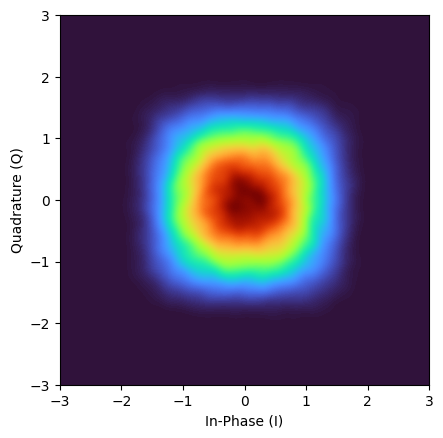

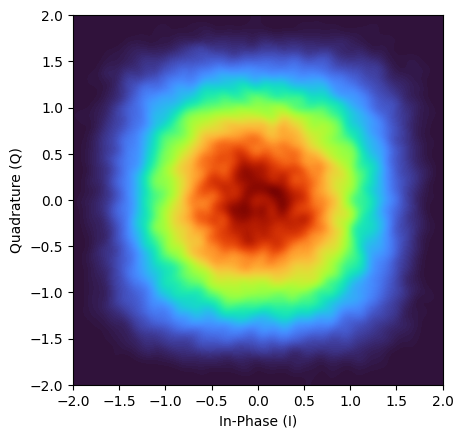

  0%|          | 0/5 [00:00<?, ?it/s]

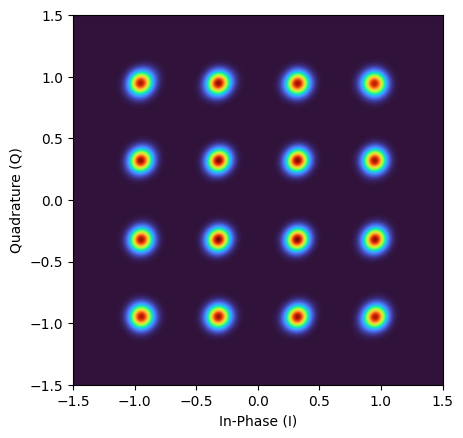

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [20]:
# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in  = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)

# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard,:], lim=True)

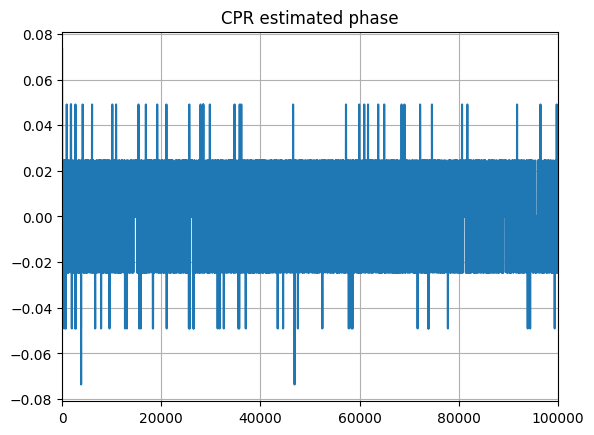

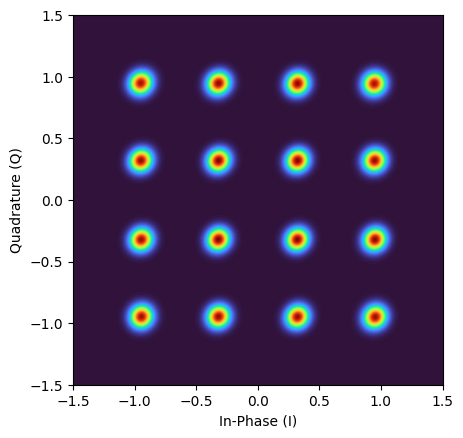

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [21]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 35
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)

In [22]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], paramTx.M, 'qam')
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :],  paramTx.M, 'qam')
MI = monteCarloMI(y_CPR[ind, :], d[ind, :],  paramTx.M, 'qam')

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]))

Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 26.28 dB
MI: 4.00 bits
GMI: 4.00 bits


## Realiza o Treinamento da Rede para todas as configurações de *Roll-off* e deslocamentos de frequência 

In [12]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
#paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 100       # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]


## Receiver parameters:

# local oscillator (LO)
#FO = paramTx.Rs/2  # frequency offset
lw = 0*200e3        # linewidth
ϕ_lo = 0            # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs
Ts = 1 / Fs

In [13]:
path = 'C:/Users/optic/Documents/PIVIC-PIBIC-Comunicacoes-Opticas/models/CONV_models/'
N = 128 # number of input amplitude samples to the NN
n0 = 32 # number of cores of 1D convolutional layers within a D/U block

Rolloff = np.arange(0.05, 0.95, 0.05)
FO_Values = np.arange(0e9, 6e9, 1e9)

for indexFO, indFO_ in enumerate(tqdm(FO_Values)):
    for indNN, indNN_ in enumerate(tqdm(Rolloff)):
        
        # Main simulation parameters
        paramTx.alphaRRC = indNN_
        FO = indFO_ + paramTx.Rs/2

        # generate optical signal signal
        sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)
        symbTx = symbTx_[:, :, chIndex]

        # simulate linear signal propagation
        sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)                  
          
        Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

        # generate LO field
        π = np.pi
        t = np.arange(0, len(sigCh))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

        sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

        # Add LO to the received signal
        sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
        sfm = sigRx.copy()
                  
        # simulate ideal direct-detection optical receiver
        Ipd = photodiode(sigRx, paramPD)
        Amp = np.sqrt(Ipd)
        Amp = resample(Amp, paramADC)

        # resampling to ADC sampling rate
        sigCh = resample(sigCh, paramADC)
        sfm = resample(sfm, paramADC)
        newFs = paramADC.SpS_out*paramTx.Rs

        sfm = sfm/np.sqrt(signal_power(sfm))
          
        # Neural network training

        #sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
        sigAmp = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

        # create set of input features
        X_train = np.zeros((len(sfm), N)) #(L,N)

        for indPhase in range(len(sfm)):
            X_train[indPhase] = sigAmp[indPhase:N+indPhase]

        # create set of phase labels
        y_train = np.array([sfm.real, sfm.imag]).T

        # define neural network model
        stop = EarlyStopping(monitor='val_loss', patience=5)
        model = create_convnet(N, n0)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        model.fit(X_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)
        #model.summary()

        model.save(path+'testModel_SpS_'+str(paramTx.SpS)+'_FO_'+str(FO/10e9)+'GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2)), save_format='h5')


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\optic\AppData\Local\Temp\ipykernel_4664\2710782859.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train[indPhase] = sigAmp[indPhase:N+indPhase]


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 156s 141ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 152s 139ms/step - loss: 0.0012 - val_loss: 7.5170e-04
Epoch 3/100
1094/1094 [==============================] - 153s 139ms/step - loss: 5.9132e-04 - val_loss: 6.3775e-04
Epoch 4/100
1094/1094 [==============================] - 152s 139ms/step - loss: 4.0721e-04 - val_loss: 3.5348e-04
Epoch 5/100
1094/1094 [==============================] - 153s 140ms/step - loss: 3.4684e-04 - val_loss: 3.5686e-04
Epoch 6/100
1094/1094 [==============================] - 152s 139ms/step - loss: 3.1602e-04 - val_loss: 4.5569e-04
Epoch 7/100
1094/1094 [==============================] - 135s 123ms/step - loss: 3.0199e-04 - val_loss: 2.8893e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 166s 150ms/step - loss: 0.0081 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 164s 150ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 147s 134ms/step - loss: 8.1275e-04 - val_loss: 6.3632e-04
Epoch 4/100
1094/1094 [==============================] - 143s 131ms/step - loss: 6.0540e-04 - val_loss: 5.4994e-04
Epoch 5/100
1094/1094 [==============================] - 155s 142ms/step - loss: 5.5246e-04 - val_loss: 5.3396e-04
Epoch 6/100
1094/1094 [==============================] - 143s 131ms/step - loss: 5.1714e-04 - val_loss: 5.0515e-04
Epoch 7/100
1094/1094 [==============================] - 143s 131ms/step - loss: 4.9964e-04 - val_loss: 5.1782e-04
Epoch 8/100
1094/1094 [==============================] - 144s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 133s 120ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 132s 120ms/step - loss: 0.0011 - val_loss: 7.5641e-04
Epoch 3/100
1094/1094 [==============================] - 132s 121ms/step - loss: 8.4009e-04 - val_loss: 8.0357e-04
Epoch 4/100
1094/1094 [==============================] - 131s 120ms/step - loss: 7.7190e-04 - val_loss: 6.8404e-04
Epoch 5/100
1094/1094 [==============================] - 131s 120ms/step - loss: 7.4420e-04 - val_loss: 6.6205e-04
Epoch 6/100
1094/1094 [==============================] - 132s 121ms/step - loss: 7.3023e-04 - val_loss: 7.5117e-04
Epoch 7/100
1094/1094 [==============================] - 133s 121ms/step - loss: 7.1788e-04 - val_loss: 6.4316e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 133s 120ms/step - loss: 0.0077 - val_loss: 0.0029
Epoch 2/100
1094/1094 [==============================] - 130s 118ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 130s 118ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0010 - val_loss: 9.2940e-04
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 9.6961e-04 - val_loss: 9.2061e-04
Epoch 6/100
1094/1094 [==============================] - 130s 119ms/step - loss: 9.4825e-04 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 130s 119ms/step - loss: 9.1891e-04 - val_loss: 8.9040e-04
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - los

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 133s 120ms/step - loss: 0.0089 - val_loss: 0.0034
Epoch 2/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 130s 118ms/step - loss: 0.0011 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 132s 119ms/step - loss: 0.0086 - val_loss: 0.0032
Epoch 2/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 130s 118ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0013 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 133s 120ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 2/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0015 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0082 - val_loss: 0.0037
Epoch 2/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 3/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0017 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 134s 121ms/step - loss: 0.0120 - val_loss: 0.0044
Epoch 2/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0019 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 133s 120ms/step - loss: 0.0101 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0021 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 134s 121ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 133s 122ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/100
1094/1094 [==============================] - 133s 122ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/100
1094/1094 [==============================] - 132s 120ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0022 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 132s 120ms/step - loss: 0.0114 - val_loss: 0.0046
Epoch 2/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/100
1094/1094 [==============================] - 130s 118ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/100
1094/1094 [==============================] - 129s 118ms/step - loss: 0.0025 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 134s 121ms/step - loss: 0.0109 - val_loss: 0.0050
Epoch 2/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 3/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 6/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0026 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 132s 119ms/step - loss: 0.0118 - val_loss: 0.0055
Epoch 2/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 3/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0028 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 134s 121ms/step - loss: 0.0126 - val_loss: 0.0054
Epoch 2/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/100
1094/1094 [==============================] - 130s 119ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/100
1094/1094 [==============================] - 131s 119ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/100
1094/1094 [==============================] - 131s 120ms/step - loss: 0.0030 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 134s 121ms/step - loss: 0.0122 - val_loss: 0.0053
Epoch 2/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/100
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0031 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0129 - val_loss: 0.0062
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 4/100
1094/1094 [==============================] - 138s 127ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0033 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 147s 133ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 2/100
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 3/100
1094/1094 [==============================] - 144s 132ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/100
1094/1094 [==============================] - 145s 133ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/100
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/100
1094/1094 [==============================] - 144s 132ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/100
1094/1094 [==============================] - 144s 132ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/100
1094/1094 [==============================] - 144s 132ms/step - loss: 0.0034 - val_loss: 0.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 139s 126ms/step - loss: 0.0074 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 138s 127ms/step - loss: 0.0011 - val_loss: 8.7239e-04
Epoch 3/100
1094/1094 [==============================] - 137s 125ms/step - loss: 3.7267e-04 - val_loss: 2.7241e-04
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.6831e-04 - val_loss: 1.2989e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.0310e-04 - val_loss: 1.0395e-04
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 8.2228e-05 - val_loss: 5.6544e-05
Epoch 7/100
1094/1094 [==============================] - 137s 125ms/step - loss: 6.3037e-05 - val_loss: 8.5206e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0010 - val_loss: 5.5300e-04
Epoch 3/100
1094/1094 [==============================] - 132s 121ms/step - loss: 3.7459e-04 - val_loss: 2.0963e-04
Epoch 4/100
1094/1094 [==============================] - 132s 121ms/step - loss: 1.9482e-04 - val_loss: 1.4085e-04
Epoch 5/100
1094/1094 [==============================] - 132s 120ms/step - loss: 1.3881e-04 - val_loss: 9.5837e-05
Epoch 6/100
1094/1094 [==============================] - 133s 122ms/step - loss: 1.1702e-04 - val_loss: 9.4138e-05
Epoch 7/100
1094/1094 [==============================] - 132s 121ms/step - loss: 9.8872e-05 - val_loss: 1.6908e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 136s 123ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 134s 122ms/step - loss: 5.4647e-04 - val_loss: 6.6342e-04
Epoch 4/100
1094/1094 [==============================] - 133s 122ms/step - loss: 3.3177e-04 - val_loss: 2.8039e-04
Epoch 5/100
1094/1094 [==============================] - 133s 121ms/step - loss: 2.5492e-04 - val_loss: 2.0299e-04
Epoch 6/100
1094/1094 [==============================] - 133s 121ms/step - loss: 2.2910e-04 - val_loss: 1.9075e-04
Epoch 7/100
1094/1094 [==============================] - 133s 122ms/step - loss: 2.1188e-04 - val_loss: 2.1680e-04
Epoch 8/100
1094/1094 [==============================] - 133s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0076 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 134s 123ms/step - loss: 7.1137e-04 - val_loss: 5.5847e-04
Epoch 4/100
1094/1094 [==============================] - 136s 124ms/step - loss: 4.8911e-04 - val_loss: 8.6272e-04
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 4.1331e-04 - val_loss: 3.5769e-04
Epoch 6/100
1094/1094 [==============================] - 138s 126ms/step - loss: 3.9138e-04 - val_loss: 3.7921e-04
Epoch 7/100
1094/1094 [==============================] - 136s 124ms/step - loss: 3.7045e-04 - val_loss: 3.6601e-04
Epoch 8/100
1094/1094 [==============================] - 134s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 140s 127ms/step - loss: 0.0077 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 137s 126ms/step - loss: 0.0011 - val_loss: 8.1814e-04
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 6.8272e-04 - val_loss: 5.9194e-04
Epoch 4/100
1094/1094 [==============================] - 137s 126ms/step - loss: 6.1520e-04 - val_loss: 5.6439e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 5.8124e-04 - val_loss: 5.5869e-04
Epoch 6/100
1094/1094 [==============================] - 137s 126ms/step - loss: 5.7074e-04 - val_loss: 5.1391e-04
Epoch 7/100
1094/1094 [==============================] - 137s 126ms/step - loss: 5.5785e-04 - val_loss: 7.0042e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0098 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0011 - val_loss: 8.8325e-04
Epoch 4/100
1094/1094 [==============================] - 136s 124ms/step - loss: 8.7176e-04 - val_loss: 8.3599e-04
Epoch 5/100
1094/1094 [==============================] - 135s 124ms/step - loss: 7.7754e-04 - val_loss: 7.1495e-04
Epoch 6/100
1094/1094 [==============================] - 135s 124ms/step - loss: 7.4551e-04 - val_loss: 7.2432e-04
Epoch 7/100
1094/1094 [==============================] - 135s 124ms/step - loss: 7.1791e-04 - val_loss: 6.8778e-04
Epoch 8/100
1094/1094 [==============================] - 136s 124m

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 136s 123ms/step - loss: 0.0105 - val_loss: 0.0034
Epoch 2/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 132s 121ms/step - loss: 9.9831e-04 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 132s 121ms/step - loss: 9.4705e-04 - val_loss: 9.6134e-04
Epoch 7/100
1094/1094 [==============================] - 133s 121ms/step - loss: 9.3239e-04 - val_loss: 8.7934e-04
Epoch 8/100
1094/1094 [==============================] - 133s 122ms/step - loss: 9

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 135s 122ms/step - loss: 0.0107 - val_loss: 0.0032
Epoch 2/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 3/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 133s 121ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 133s 122ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 133s 122ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0011 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 139s 125ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0013 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 145s 131ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0015 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 140s 127ms/step - loss: 0.0105 - val_loss: 0.0039
Epoch 2/100
1094/1094 [==============================] - 138s 127ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0017 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0086 - val_loss: 0.0038
Epoch 2/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 3/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0018 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 2/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 3/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
1094/1094 [==============================] - 132s 121ms/step - loss: 0.0020 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 138s 125ms/step - loss: 0.0103 - val_loss: 0.0047
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0022 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 127ms/step - loss: 0.0094 - val_loss: 0.0048
Epoch 2/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/100
1094/1094 [==============================] - 137s 126ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/100
1094/1094 [==============================] - 137s 126ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0024 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 140s 127ms/step - loss: 0.0120 - val_loss: 0.0052
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 3/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/100
1094/1094 [==============================] - 136s 125ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0026 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0099 - val_loss: 0.0049
Epoch 2/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 3/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0028 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 136s 123ms/step - loss: 0.0106 - val_loss: 0.0055
Epoch 2/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0030 - val_loss: 0.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0107 - val_loss: 0.0024
Epoch 2/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 135s 124ms/step - loss: 8.3693e-04 - val_loss: 5.0169e-04
Epoch 4/100
1094/1094 [==============================] - 135s 124ms/step - loss: 3.7203e-04 - val_loss: 2.7899e-04
Epoch 5/100
1094/1094 [==============================] - 134s 123ms/step - loss: 1.9336e-04 - val_loss: 2.3100e-04
Epoch 6/100
1094/1094 [==============================] - 135s 123ms/step - loss: 1.2520e-04 - val_loss: 2.3884e-04
Epoch 7/100
1094/1094 [==============================] - 136s 125ms/step - loss: 9.0834e-05 - val_loss: 6.7620e-05
Epoch 8/100
1094/1094 [==============================] - 133s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 154s 139ms/step - loss: 0.0073 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 142s 129ms/step - loss: 8.4660e-04 - val_loss: 4.9505e-04
Epoch 3/100
1094/1094 [==============================] - 144s 132ms/step - loss: 2.8161e-04 - val_loss: 1.6112e-04
Epoch 4/100
1094/1094 [==============================] - 141s 129ms/step - loss: 1.3309e-04 - val_loss: 9.7329e-05
Epoch 5/100
1094/1094 [==============================] - 142s 130ms/step - loss: 9.4413e-05 - val_loss: 5.0350e-05
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 6.6831e-05 - val_loss: 3.7055e-05
Epoch 7/100
1094/1094 [==============================] - 142s 129ms/step - loss: 5.2465e-05 - val_loss: 5.0900e-05
Epoch 8/100
1094/1094 [==============================]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0086 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0011 - val_loss: 5.5216e-04
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 3.7818e-04 - val_loss: 3.0975e-04
Epoch 4/100
1094/1094 [==============================] - 142s 129ms/step - loss: 1.8681e-04 - val_loss: 1.1039e-04
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 1.1935e-04 - val_loss: 8.6308e-05
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 9.1963e-05 - val_loss: 6.2255e-05
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 7.7018e-05 - val_loss: 1.6949e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 138s 125ms/step - loss: 0.0072 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0011 - val_loss: 5.9985e-04
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 4.1942e-04 - val_loss: 3.0057e-04
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 2.0928e-04 - val_loss: 1.8459e-04
Epoch 5/100
1094/1094 [==============================] - 136s 125ms/step - loss: 1.5229e-04 - val_loss: 1.3716e-04
Epoch 6/100
1094/1094 [==============================] - 136s 124ms/step - loss: 1.2130e-04 - val_loss: 1.0710e-04
Epoch 7/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.1385e-04 - val_loss: 1.0008e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 136s 123ms/step - loss: 0.0078 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 134s 123ms/step - loss: 0.0013 - val_loss: 7.6223e-04
Epoch 3/100
1094/1094 [==============================] - 134s 123ms/step - loss: 5.3256e-04 - val_loss: 3.6293e-04
Epoch 4/100
1094/1094 [==============================] - 135s 123ms/step - loss: 3.3963e-04 - val_loss: 3.0265e-04
Epoch 5/100
1094/1094 [==============================] - 134s 123ms/step - loss: 2.6993e-04 - val_loss: 2.4730e-04
Epoch 6/100
1094/1094 [==============================] - 135s 124ms/step - loss: 2.4411e-04 - val_loss: 2.2212e-04
Epoch 7/100
1094/1094 [==============================] - 135s 123ms/step - loss: 2.2387e-04 - val_loss: 1.9424e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 135s 122ms/step - loss: 0.0096 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0016 - val_loss: 9.9107e-04
Epoch 3/100
1094/1094 [==============================] - 134s 123ms/step - loss: 7.5302e-04 - val_loss: 6.8162e-04
Epoch 4/100
1094/1094 [==============================] - 134s 122ms/step - loss: 4.9462e-04 - val_loss: 4.0417e-04
Epoch 5/100
1094/1094 [==============================] - 134s 122ms/step - loss: 4.1745e-04 - val_loss: 5.0960e-04
Epoch 6/100
1094/1094 [==============================] - 134s 123ms/step - loss: 3.8385e-04 - val_loss: 3.2933e-04
Epoch 7/100
1094/1094 [==============================] - 134s 122ms/step - loss: 3.6388e-04 - val_loss: 3.2548e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 140s 127ms/step - loss: 0.0080 - val_loss: 0.0024
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 137s 125ms/step - loss: 8.8513e-04 - val_loss: 7.3906e-04
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 6.4178e-04 - val_loss: 7.2139e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 5.5881e-04 - val_loss: 5.1065e-04
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 5.2556e-04 - val_loss: 4.9176e-04
Epoch 7/100
1094/1094 [==============================] - 145s 132ms/step - loss: 5.0449e-04 - val_loss: 5.7688e-04
Epoch 8/100
1094/1094 [==============================] - 157s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 142s 128ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 142s 130ms/step - loss: 9.2964e-04 - val_loss: 9.1479e-04
Epoch 4/100
1094/1094 [==============================] - 144s 131ms/step - loss: 7.5704e-04 - val_loss: 7.2298e-04
Epoch 5/100
1094/1094 [==============================] - 141s 129ms/step - loss: 7.0636e-04 - val_loss: 6.3820e-04
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 6.7430e-04 - val_loss: 6.3317e-04
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 6.5631e-04 - val_loss: 6.6989e-04
Epoch 8/100
1094/1094 [==============================] - 140s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 138s 125ms/step - loss: 0.0082 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0012 - val_loss: 9.7606e-04
Epoch 4/100
1094/1094 [==============================] - 135s 124ms/step - loss: 9.5810e-04 - val_loss: 8.8908e-04
Epoch 5/100
1094/1094 [==============================] - 136s 124ms/step - loss: 8.7824e-04 - val_loss: 8.3829e-04
Epoch 6/100
1094/1094 [==============================] - 136s 124ms/step - loss: 8.3463e-04 - val_loss: 8.6694e-04
Epoch 7/100
1094/1094 [==============================] - 137s 125ms/step - loss: 8.2528e-04 - val_loss: 0.0010
Epoch 8/100
1094/1094 [==============================] - 136s 124ms/st

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 138s 125ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 134s 122ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/100
1094/1094 [==============================] - 135s 123ms/step - loss: 0.0010 - val_loss: 9.6005e-04
Epoch 7/100
1094/1094 [==============================] - 134s 123ms/step - loss: 9.8864e-04 - val_loss: 9.6161e-04
Epoch 8/100
1094/1094 [==============================] - 136s 124ms/step - loss: 9.7225e-0

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 138s 125ms/step - loss: 0.0072 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 136s 125ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0012 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 146s 132ms/step - loss: 0.0114 - val_loss: 0.0039
Epoch 2/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/100
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/100
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 144s 132ms/step - loss: 0.0014 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 142s 128ms/step - loss: 0.0095 - val_loss: 0.0036
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 137s 126ms/step - loss: 0.0015 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 139s 126ms/step - loss: 0.0098 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0017 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0105 - val_loss: 0.0042
Epoch 2/100
1094/1094 [==============================] - 136s 125ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 3/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 135s 124ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0019 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0104 - val_loss: 0.0044
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/100
1094/1094 [==============================] - 136s 125ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/100
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0021 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0098 - val_loss: 0.0046
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0023 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0099 - val_loss: 0.0048
Epoch 2/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0024 - val_loss: 0.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 139s 126ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 8.4121e-04 - val_loss: 4.5778e-04
Epoch 3/100
1094/1094 [==============================] - 137s 125ms/step - loss: 2.9773e-04 - val_loss: 1.8347e-04
Epoch 4/100
1094/1094 [==============================] - 138s 126ms/step - loss: 1.5575e-04 - val_loss: 1.0775e-04
Epoch 5/100
1094/1094 [==============================] - 138s 126ms/step - loss: 1.0495e-04 - val_loss: 8.1189e-05
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 7.3676e-05 - val_loss: 7.3223e-05
Epoch 7/100
1094/1094 [==============================] - 137s 125ms/step - loss: 5.9737e-05 - val_loss: 4.3908e-05
Epoch 8/100
1094/1094 [==============================]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 138s 125ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0010 - val_loss: 5.3187e-04
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 3.6952e-04 - val_loss: 2.1025e-04
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.7394e-04 - val_loss: 1.0236e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.0666e-04 - val_loss: 6.3118e-05
Epoch 6/100
1094/1094 [==============================] - 136s 124ms/step - loss: 7.9836e-05 - val_loss: 4.4371e-05
Epoch 7/100
1094/1094 [==============================] - 138s 126ms/step - loss: 5.7052e-05 - val_loss: 5.5061e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0075 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0013 - val_loss: 7.2707e-04
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 4.5086e-04 - val_loss: 2.4491e-04
Epoch 4/100
1094/1094 [==============================] - 135s 123ms/step - loss: 2.0347e-04 - val_loss: 1.2261e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.2327e-04 - val_loss: 6.2670e-05
Epoch 6/100
1094/1094 [==============================] - 135s 124ms/step - loss: 8.7157e-05 - val_loss: 5.3372e-05
Epoch 7/100
1094/1094 [==============================] - 135s 124ms/step - loss: 6.4109e-05 - val_loss: 5.5888e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 146s 131ms/step - loss: 0.0085 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 9.7900e-04 - val_loss: 5.1241e-04
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 3.3473e-04 - val_loss: 1.5815e-04
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 1.6111e-04 - val_loss: 9.9459e-05
Epoch 5/100
1094/1094 [==============================] - 141s 129ms/step - loss: 1.1124e-04 - val_loss: 5.3761e-05
Epoch 6/100
1094/1094 [==============================] - 141s 129ms/step - loss: 8.1127e-05 - val_loss: 4.6263e-05
Epoch 7/100
1094/1094 [==============================] - 141s 129ms/step - loss: 6.7319e-05 - val_loss: 1.0064e-04
Epoch 8/100
1094/1094 [==============================]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0011 - val_loss: 8.5749e-04
Epoch 3/100
1094/1094 [==============================] - 143s 131ms/step - loss: 3.6839e-04 - val_loss: 1.8459e-04
Epoch 4/100
1094/1094 [==============================] - 143s 131ms/step - loss: 1.7724e-04 - val_loss: 1.4554e-04
Epoch 5/100
1094/1094 [==============================] - 142s 130ms/step - loss: 1.1789e-04 - val_loss: 1.0067e-04
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 9.6399e-05 - val_loss: 6.8338e-05
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 8.0979e-05 - val_loss: 6.6132e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 140s 127ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0012 - val_loss: 8.9993e-04
Epoch 3/100
1094/1094 [==============================] - 139s 127ms/step - loss: 4.6487e-04 - val_loss: 4.4354e-04
Epoch 4/100
1094/1094 [==============================] - 138s 126ms/step - loss: 2.3791e-04 - val_loss: 2.0697e-04
Epoch 5/100
1094/1094 [==============================] - 138s 126ms/step - loss: 1.7693e-04 - val_loss: 1.7707e-04
Epoch 6/100
1094/1094 [==============================] - 137s 126ms/step - loss: 1.5489e-04 - val_loss: 1.3327e-04
Epoch 7/100
1094/1094 [==============================] - 138s 126ms/step - loss: 1.4230e-04 - val_loss: 1.1353e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 139s 126ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0012 - val_loss: 6.7607e-04
Epoch 3/100
1094/1094 [==============================] - 136s 125ms/step - loss: 5.1858e-04 - val_loss: 3.9089e-04
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 3.3304e-04 - val_loss: 2.5832e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 2.8364e-04 - val_loss: 2.6274e-04
Epoch 6/100
1094/1094 [==============================] - 137s 126ms/step - loss: 2.4778e-04 - val_loss: 2.1001e-04
Epoch 7/100
1094/1094 [==============================] - 138s 126ms/step - loss: 2.4189e-04 - val_loss: 1.9852e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 139s 126ms/step - loss: 0.0093 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 7.8853e-04 - val_loss: 6.3288e-04
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 4.8886e-04 - val_loss: 4.4422e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 4.0538e-04 - val_loss: 4.1920e-04
Epoch 6/100
1094/1094 [==============================] - 136s 124ms/step - loss: 3.7028e-04 - val_loss: 3.4892e-04
Epoch 7/100
1094/1094 [==============================] - 136s 125ms/step - loss: 3.5211e-04 - val_loss: 3.4600e-04
Epoch 8/100
1094/1094 [==============================] - 137s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 7.7942e-04 - val_loss: 6.3409e-04
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 5.8540e-04 - val_loss: 4.8777e-04
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 5.1801e-04 - val_loss: 5.1959e-04
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 4.9996e-04 - val_loss: 5.1178e-04
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 4.8825e-04 - val_loss: 5.1038e-04
Epoch 8/100
1094/1094 [==============================] - 140s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 143s 129ms/step - loss: 0.0086 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0015 - val_loss: 9.2928e-04
Epoch 3/100
1094/1094 [==============================] - 143s 131ms/step - loss: 8.3809e-04 - val_loss: 7.5228e-04
Epoch 4/100
1094/1094 [==============================] - 144s 132ms/step - loss: 7.1222e-04 - val_loss: 6.3841e-04
Epoch 5/100
1094/1094 [==============================] - 142s 130ms/step - loss: 6.7534e-04 - val_loss: 6.7699e-04
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 6.5099e-04 - val_loss: 6.8884e-04
Epoch 7/100
1094/1094 [==============================] - 142s 130ms/step - loss: 6.4199e-04 - val_loss: 6.9409e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 153s 138ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 146s 133ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 145s 132ms/step - loss: 9.6345e-04 - val_loss: 0.0010
Epoch 4/100
1094/1094 [==============================] - 146s 134ms/step - loss: 8.2629e-04 - val_loss: 7.6655e-04
Epoch 5/100
1094/1094 [==============================] - 145s 133ms/step - loss: 7.8226e-04 - val_loss: 7.8623e-04
Epoch 6/100
1094/1094 [==============================] - 145s 133ms/step - loss: 7.7139e-04 - val_loss: 7.5593e-04
Epoch 7/100
1094/1094 [==============================] - 144s 132ms/step - loss: 7.5782e-04 - val_loss: 8.1076e-04
Epoch 8/100
1094/1094 [==============================] - 145s 133m

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 140s 127ms/step - loss: 0.0078 - val_loss: 0.0029
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 3/100
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
1094/1094 [==============================] - 138s 127ms/step - loss: 0.0011 - val_loss: 9.6131e-04
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 9.8830e-04 - val_loss: 8.8823e-04
Epoch 6/100
1094/1094 [==============================] - 138s 126ms/step - loss: 9.6953e-04 - val_loss: 9.3073e-04
Epoch 7/100
1094/1094 [==============================] - 138s 126ms/step - loss: 9.4656e-04 - val_loss: 8.7550e-04
Epoch 8/100
1094/1094 [==============================] - 138s 126ms/step -

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0103 - val_loss: 0.0035
Epoch 2/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 137s 126ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0011 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0104 - val_loss: 0.0031
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0013 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 127ms/step - loss: 0.0114 - val_loss: 0.0038
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 138s 127ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 138s 127ms/step - loss: 0.0014 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0094 - val_loss: 0.0039
Epoch 2/100
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 3/100
1094/1094 [==============================] - 143s 130ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/100
1094/1094 [==============================] - 159s 145ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
1094/1094 [==============================] - 154s 141ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/100
1094/1094 [==============================] - 153s 139ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/100
1094/1094 [==============================] - 153s 140ms/step - loss: 0.0016 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0099 - val_loss: 0.0044
Epoch 2/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/100
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/100
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 7/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/100
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0018 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 127ms/step - loss: 0.0094 - val_loss: 0.0044
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
1094/1094 [==============================] - 138s 127ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/100
1094/1094 [==============================] - 138s 126ms/step - loss: 0.0020 - val_loss: 0.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 147s 132ms/step - loss: 0.0060 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 144s 131ms/step - loss: 9.4317e-04 - val_loss: 6.7761e-04
Epoch 3/100
1094/1094 [==============================] - 144s 132ms/step - loss: 3.5420e-04 - val_loss: 2.7728e-04
Epoch 4/100
1094/1094 [==============================] - 144s 132ms/step - loss: 1.7774e-04 - val_loss: 1.4011e-04
Epoch 5/100
1094/1094 [==============================] - 144s 132ms/step - loss: 1.0588e-04 - val_loss: 7.0287e-05
Epoch 6/100
1094/1094 [==============================] - 156s 143ms/step - loss: 7.8977e-05 - val_loss: 4.6135e-05
Epoch 7/100
1094/1094 [==============================] - 144s 132ms/step - loss: 6.1091e-05 - val_loss: 3.0106e-05
Epoch 8/100
1094/1094 [==============================]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 143s 130ms/step - loss: 0.0068 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0010 - val_loss: 6.2081e-04
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 4.0365e-04 - val_loss: 2.5062e-04
Epoch 4/100
1094/1094 [==============================] - 144s 131ms/step - loss: 1.8775e-04 - val_loss: 1.5732e-04
Epoch 5/100
1094/1094 [==============================] - 142s 130ms/step - loss: 1.1213e-04 - val_loss: 5.3157e-05
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 7.8817e-05 - val_loss: 4.7808e-05
Epoch 7/100
1094/1094 [==============================] - 142s 130ms/step - loss: 5.7562e-05 - val_loss: 3.9980e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 127ms/step - loss: 0.0069 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0011 - val_loss: 6.0011e-04
Epoch 3/100
1094/1094 [==============================] - 139s 127ms/step - loss: 3.8756e-04 - val_loss: 1.8635e-04
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 1.8827e-04 - val_loss: 1.7749e-04
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 1.1781e-04 - val_loss: 1.2917e-04
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 8.5218e-05 - val_loss: 6.2093e-05
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 6.6558e-05 - val_loss: 6.3314e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 140s 126ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0011 - val_loss: 6.5304e-04
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 3.8045e-04 - val_loss: 2.3762e-04
Epoch 4/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.8139e-04 - val_loss: 1.1155e-04
Epoch 5/100
1094/1094 [==============================] - 137s 126ms/step - loss: 1.1074e-04 - val_loss: 1.5351e-04
Epoch 6/100
1094/1094 [==============================] - 138s 126ms/step - loss: 7.8445e-05 - val_loss: 4.4346e-05
Epoch 7/100
1094/1094 [==============================] - 141s 129ms/step - loss: 6.1074e-05 - val_loss: 3.4032e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 139s 126ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0012 - val_loss: 6.2424e-04
Epoch 3/100
1094/1094 [==============================] - 138s 126ms/step - loss: 4.4850e-04 - val_loss: 2.4104e-04
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 2.0026e-04 - val_loss: 1.7431e-04
Epoch 5/100
1094/1094 [==============================] - 137s 125ms/step - loss: 1.2122e-04 - val_loss: 6.4068e-05
Epoch 6/100
1094/1094 [==============================] - 137s 125ms/step - loss: 8.1808e-05 - val_loss: 5.1260e-05
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 5.9066e-05 - val_loss: 3.9860e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0092 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0013 - val_loss: 6.8387e-04
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 4.5166e-04 - val_loss: 2.3144e-04
Epoch 4/100
1094/1094 [==============================] - 141s 129ms/step - loss: 1.9688e-04 - val_loss: 1.2120e-04
Epoch 5/100
1094/1094 [==============================] - 142s 129ms/step - loss: 1.1749e-04 - val_loss: 9.3543e-05
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 8.3356e-05 - val_loss: 1.8760e-04
Epoch 7/100
1094/1094 [==============================] - 142s 130ms/step - loss: 7.2202e-05 - val_loss: 4.3950e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 148s 134ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 148s 135ms/step - loss: 0.0013 - val_loss: 8.4948e-04
Epoch 3/100
1094/1094 [==============================] - 147s 134ms/step - loss: 4.9041e-04 - val_loss: 3.9843e-04
Epoch 4/100
1094/1094 [==============================] - 144s 132ms/step - loss: 2.1658e-04 - val_loss: 1.5699e-04
Epoch 5/100
1094/1094 [==============================] - 147s 134ms/step - loss: 1.3835e-04 - val_loss: 1.2805e-04
Epoch 6/100
1094/1094 [==============================] - 147s 134ms/step - loss: 1.0265e-04 - val_loss: 9.7717e-05
Epoch 7/100
1094/1094 [==============================] - 146s 133ms/step - loss: 9.3876e-05 - val_loss: 7.1626e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 128ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0015 - val_loss: 9.1400e-04
Epoch 3/100
1094/1094 [==============================] - 139s 127ms/step - loss: 5.7663e-04 - val_loss: 3.2401e-04
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 2.8000e-04 - val_loss: 1.9019e-04
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 1.9560e-04 - val_loss: 1.7456e-04
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 1.7001e-04 - val_loss: 1.4126e-04
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 1.6026e-04 - val_loss: 1.3493e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 127ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0014 - val_loss: 8.5756e-04
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 6.0859e-04 - val_loss: 4.5213e-04
Epoch 4/100
1094/1094 [==============================] - 143s 131ms/step - loss: 3.6048e-04 - val_loss: 3.2826e-04
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 2.9527e-04 - val_loss: 3.2440e-04
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 2.6976e-04 - val_loss: 2.4436e-04
Epoch 7/100
1094/1094 [==============================] - 141s 129ms/step - loss: 2.6095e-04 - val_loss: 3.4665e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 141s 127ms/step - loss: 0.0104 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 139s 127ms/step - loss: 8.7670e-04 - val_loss: 5.6443e-04
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 5.3596e-04 - val_loss: 4.0519e-04
Epoch 5/100
1094/1094 [==============================] - 138s 126ms/step - loss: 4.1824e-04 - val_loss: 3.5689e-04
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 3.8191e-04 - val_loss: 3.7078e-04
Epoch 7/100
1094/1094 [==============================] - 138s 127ms/step - loss: 3.6980e-04 - val_loss: 3.3142e-04
Epoch 8/100
1094/1094 [==============================] - 140s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 144s 130ms/step - loss: 0.0074 - val_loss: 0.0025
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0016 - val_loss: 9.9787e-04
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 7.6681e-04 - val_loss: 5.3582e-04
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 5.6784e-04 - val_loss: 5.6752e-04
Epoch 5/100
1094/1094 [==============================] - 141s 128ms/step - loss: 5.0742e-04 - val_loss: 5.0955e-04
Epoch 6/100
1094/1094 [==============================] - 141s 129ms/step - loss: 4.9769e-04 - val_loss: 4.6913e-04
Epoch 7/100
1094/1094 [==============================] - 141s 129ms/step - loss: 4.8121e-04 - val_loss: 5.2680e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 143s 129ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 2/100
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 8.7261e-04 - val_loss: 6.9696e-04
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 7.2009e-04 - val_loss: 6.7731e-04
Epoch 5/100
1094/1094 [==============================] - 141s 129ms/step - loss: 6.8382e-04 - val_loss: 6.9266e-04
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 6.4946e-04 - val_loss: 5.8178e-04
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 6.4005e-04 - val_loss: 6.7823e-04
Epoch 8/100
1094/1094 [==============================] - 139s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 145s 130ms/step - loss: 0.0077 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 149s 136ms/step - loss: 0.0011 - val_loss: 8.3354e-04
Epoch 4/100
1094/1094 [==============================] - 142s 130ms/step - loss: 8.5876e-04 - val_loss: 7.6331e-04
Epoch 5/100
1094/1094 [==============================] - 144s 131ms/step - loss: 7.9630e-04 - val_loss: 7.7672e-04
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 7.6912e-04 - val_loss: 7.2139e-04
Epoch 7/100
1094/1094 [==============================] - 142s 130ms/step - loss: 7.6268e-04 - val_loss: 7.1926e-04
Epoch 8/100
1094/1094 [==============================] - 142s 130m

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 142s 128ms/step - loss: 0.0077 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0012 - val_loss: 9.8524e-04
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 9.8897e-04 - val_loss: 9.3348e-04
Epoch 5/100
1094/1094 [==============================] - 138s 127ms/step - loss: 9.3443e-04 - val_loss: 9.5223e-04
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 9.1397e-04 - val_loss: 8.8402e-04
Epoch 7/100
1094/1094 [==============================] - 138s 127ms/step - loss: 9.0032e-04 - val_loss: 9.9038e-04
Epoch 8/100
1094/1094 [==============================] - 139s 127m

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 142s 128ms/step - loss: 0.0085 - val_loss: 0.0034
Epoch 2/100
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0010 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 149s 135ms/step - loss: 0.0084 - val_loss: 0.0033
Epoch 2/100
1094/1094 [==============================] - 146s 134ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/100
1094/1094 [==============================] - 146s 134ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/100
1094/1094 [==============================] - 146s 134ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 146s 134ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 147s 134ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 146s 134ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
1094/1094 [==============================] - 147s 134ms/step - loss: 0.0012 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 143s 130ms/step - loss: 0.0101 - val_loss: 0.0040
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0014 - val_loss: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 143s 129ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
1094/1094 [==============================] - 139s 127ms/step - loss: 0.0015 - val_loss: 0.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0105 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 139s 127ms/step - loss: 7.1845e-04 - val_loss: 4.2424e-04
Epoch 4/100
1094/1094 [==============================] - 139s 127ms/step - loss: 3.5088e-04 - val_loss: 3.2623e-04
Epoch 5/100
1094/1094 [==============================] - 139s 127ms/step - loss: 1.9208e-04 - val_loss: 1.6693e-04
Epoch 6/100
1094/1094 [==============================] - 139s 127ms/step - loss: 1.2126e-04 - val_loss: 7.4105e-05
Epoch 7/100
1094/1094 [==============================] - 139s 127ms/step - loss: 8.9226e-05 - val_loss: 1.8975e-04
Epoch 8/100
1094/1094 [==============================] - 139s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 143s 129ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0010 - val_loss: 5.2397e-04
Epoch 3/100
1094/1094 [==============================] - 141s 129ms/step - loss: 3.8894e-04 - val_loss: 2.1005e-04
Epoch 4/100
1094/1094 [==============================] - 140s 128ms/step - loss: 1.8237e-04 - val_loss: 2.5617e-04
Epoch 5/100
1094/1094 [==============================] - 140s 128ms/step - loss: 1.0881e-04 - val_loss: 6.2192e-05
Epoch 6/100
1094/1094 [==============================] - 141s 129ms/step - loss: 7.5090e-05 - val_loss: 3.8565e-05
Epoch 7/100
1094/1094 [==============================] - 140s 128ms/step - loss: 5.5401e-05 - val_loss: 3.8495e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 168s 152ms/step - loss: 0.0068 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 158s 144ms/step - loss: 0.0011 - val_loss: 7.2832e-04
Epoch 3/100
1094/1094 [==============================] - 158s 145ms/step - loss: 4.1595e-04 - val_loss: 2.5195e-04
Epoch 4/100
1094/1094 [==============================] - 159s 145ms/step - loss: 2.0203e-04 - val_loss: 1.3002e-04
Epoch 5/100
1094/1094 [==============================] - 160s 147ms/step - loss: 1.2215e-04 - val_loss: 8.2342e-05
Epoch 6/100
1094/1094 [==============================] - 160s 146ms/step - loss: 8.2359e-05 - val_loss: 5.3036e-05
Epoch 7/100
1094/1094 [==============================] - 158s 144ms/step - loss: 6.1661e-05 - val_loss: 6.4937e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 150s 136ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 146s 134ms/step - loss: 0.0012 - val_loss: 7.4106e-04
Epoch 3/100
1094/1094 [==============================] - 147s 135ms/step - loss: 4.4324e-04 - val_loss: 2.7326e-04
Epoch 4/100
1094/1094 [==============================] - 147s 134ms/step - loss: 1.9985e-04 - val_loss: 1.1686e-04
Epoch 5/100
1094/1094 [==============================] - 149s 136ms/step - loss: 1.0873e-04 - val_loss: 6.0491e-05
Epoch 6/100
1094/1094 [==============================] - 145s 133ms/step - loss: 7.7227e-05 - val_loss: 4.9714e-05
Epoch 7/100
1094/1094 [==============================] - 146s 133ms/step - loss: 5.9918e-05 - val_loss: 2.2355e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 164s 148ms/step - loss: 0.0076 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 149s 136ms/step - loss: 0.0012 - val_loss: 8.2685e-04
Epoch 3/100
1094/1094 [==============================] - 150s 137ms/step - loss: 4.7410e-04 - val_loss: 2.6107e-04
Epoch 4/100
1094/1094 [==============================] - 147s 134ms/step - loss: 2.0241e-04 - val_loss: 1.2223e-04
Epoch 5/100
1094/1094 [==============================] - 149s 136ms/step - loss: 1.0510e-04 - val_loss: 1.3840e-04
Epoch 6/100
1094/1094 [==============================] - 145s 132ms/step - loss: 6.8855e-05 - val_loss: 6.4417e-05
Epoch 7/100
1094/1094 [==============================] - 145s 133ms/step - loss: 5.0377e-05 - val_loss: 3.0944e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 146s 133ms/step - loss: 0.0077 - val_loss: 0.0018
Epoch 2/100
1094/1094 [==============================] - 145s 133ms/step - loss: 0.0012 - val_loss: 7.4759e-04
Epoch 3/100
1094/1094 [==============================] - 142s 130ms/step - loss: 3.9232e-04 - val_loss: 2.1685e-04
Epoch 4/100
1094/1094 [==============================] - 144s 131ms/step - loss: 1.6842e-04 - val_loss: 1.2563e-04
Epoch 5/100
1094/1094 [==============================] - 143s 131ms/step - loss: 9.8307e-05 - val_loss: 4.9594e-05
Epoch 6/100
1094/1094 [==============================] - 144s 132ms/step - loss: 6.4661e-05 - val_loss: 3.6365e-05
Epoch 7/100
1094/1094 [==============================] - 145s 132ms/step - loss: 4.9703e-05 - val_loss: 1.1114e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 148s 134ms/step - loss: 0.0078 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 147s 134ms/step - loss: 0.0013 - val_loss: 6.8348e-04
Epoch 3/100
1094/1094 [==============================] - 143s 131ms/step - loss: 4.5728e-04 - val_loss: 2.1993e-04
Epoch 4/100
1094/1094 [==============================] - 143s 130ms/step - loss: 1.9366e-04 - val_loss: 1.0622e-04
Epoch 5/100
1094/1094 [==============================] - 144s 131ms/step - loss: 1.0915e-04 - val_loss: 7.4398e-05
Epoch 6/100
1094/1094 [==============================] - 145s 133ms/step - loss: 7.6502e-05 - val_loss: 3.8138e-05
Epoch 7/100
1094/1094 [==============================] - 154s 141ms/step - loss: 5.9770e-05 - val_loss: 5.6564e-05
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 152s 138ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 2/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0014 - val_loss: 7.4626e-04
Epoch 3/100
1094/1094 [==============================] - 150s 137ms/step - loss: 5.1059e-04 - val_loss: 4.1819e-04
Epoch 4/100
1094/1094 [==============================] - 149s 137ms/step - loss: 1.9911e-04 - val_loss: 1.2913e-04
Epoch 5/100
1094/1094 [==============================] - 150s 137ms/step - loss: 1.1597e-04 - val_loss: 8.3202e-05
Epoch 6/100
1094/1094 [==============================] - 150s 137ms/step - loss: 9.0504e-05 - val_loss: 8.1938e-05
Epoch 7/100
1094/1094 [==============================] - 150s 137ms/step - loss: 7.5668e-05 - val_loss: 1.4734e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 153s 139ms/step - loss: 0.0070 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 153s 140ms/step - loss: 0.0014 - val_loss: 7.7669e-04
Epoch 3/100
1094/1094 [==============================] - 151s 138ms/step - loss: 5.0023e-04 - val_loss: 3.3900e-04
Epoch 4/100
1094/1094 [==============================] - 151s 138ms/step - loss: 2.3596e-04 - val_loss: 1.6999e-04
Epoch 5/100
1094/1094 [==============================] - 151s 138ms/step - loss: 1.6188e-04 - val_loss: 1.3923e-04
Epoch 6/100
1094/1094 [==============================] - 152s 139ms/step - loss: 1.3708e-04 - val_loss: 1.7304e-04
Epoch 7/100
1094/1094 [==============================] - 150s 138ms/step - loss: 1.2355e-04 - val_loss: 1.4854e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 152s 137ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 2/100
1094/1094 [==============================] - 147s 134ms/step - loss: 0.0014 - val_loss: 9.0831e-04
Epoch 3/100
1094/1094 [==============================] - 148s 136ms/step - loss: 5.1890e-04 - val_loss: 3.6062e-04
Epoch 4/100
1094/1094 [==============================] - 144s 132ms/step - loss: 2.7764e-04 - val_loss: 2.3305e-04
Epoch 5/100
1094/1094 [==============================] - 142s 130ms/step - loss: 2.1201e-04 - val_loss: 1.7948e-04
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 1.9377e-04 - val_loss: 1.5912e-04
Epoch 7/100
1094/1094 [==============================] - 144s 131ms/step - loss: 1.8562e-04 - val_loss: 1.5839e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 146s 132ms/step - loss: 0.0087 - val_loss: 0.0021
Epoch 2/100
1094/1094 [==============================] - 150s 137ms/step - loss: 0.0014 - val_loss: 7.2828e-04
Epoch 3/100
1094/1094 [==============================] - 148s 135ms/step - loss: 5.7208e-04 - val_loss: 3.9554e-04
Epoch 4/100
1094/1094 [==============================] - 147s 134ms/step - loss: 3.6833e-04 - val_loss: 2.9494e-04
Epoch 5/100
1094/1094 [==============================] - 147s 134ms/step - loss: 3.2029e-04 - val_loss: 2.6192e-04
Epoch 6/100
1094/1094 [==============================] - 142s 130ms/step - loss: 3.0314e-04 - val_loss: 2.7504e-04
Epoch 7/100
1094/1094 [==============================] - 144s 132ms/step - loss: 2.8407e-04 - val_loss: 2.6375e-04
Epoch 8/100
1094/1094 [==============================] - 1

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 161s 146ms/step - loss: 0.0082 - val_loss: 0.0028
Epoch 2/100
1094/1094 [==============================] - 150s 137ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 3/100
1094/1094 [==============================] - 149s 136ms/step - loss: 7.7119e-04 - val_loss: 5.0844e-04
Epoch 4/100
1094/1094 [==============================] - 151s 138ms/step - loss: 4.9924e-04 - val_loss: 4.2101e-04
Epoch 5/100
1094/1094 [==============================] - 148s 136ms/step - loss: 4.2269e-04 - val_loss: 5.8438e-04
Epoch 6/100
1094/1094 [==============================] - 149s 136ms/step - loss: 4.0107e-04 - val_loss: 3.3582e-04
Epoch 7/100
1094/1094 [==============================] - 149s 137ms/step - loss: 3.8280e-04 - val_loss: 4.0946e-04
Epoch 8/100
1094/1094 [==============================] - 149s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 154s 140ms/step - loss: 0.0084 - val_loss: 0.0029
Epoch 2/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 151s 138ms/step - loss: 9.1520e-04 - val_loss: 8.1239e-04
Epoch 4/100
1094/1094 [==============================] - 151s 138ms/step - loss: 6.2454e-04 - val_loss: 5.1745e-04
Epoch 5/100
1094/1094 [==============================] - 151s 138ms/step - loss: 5.5336e-04 - val_loss: 4.9360e-04
Epoch 6/100
1094/1094 [==============================] - 153s 139ms/step - loss: 5.2363e-04 - val_loss: 5.8760e-04
Epoch 7/100
1094/1094 [==============================] - 151s 138ms/step - loss: 5.0897e-04 - val_loss: 5.0798e-04
Epoch 8/100
1094/1094 [==============================] - 151s 

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 159s 144ms/step - loss: 0.0085 - val_loss: 0.0032
Epoch 2/100
1094/1094 [==============================] - 157s 143ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 3/100
1094/1094 [==============================] - 155s 142ms/step - loss: 0.0010 - val_loss: 7.5781e-04
Epoch 4/100
1094/1094 [==============================] - 155s 142ms/step - loss: 7.1944e-04 - val_loss: 6.1701e-04
Epoch 5/100
1094/1094 [==============================] - 156s 142ms/step - loss: 6.5228e-04 - val_loss: 6.2653e-04
Epoch 6/100
1094/1094 [==============================] - 155s 142ms/step - loss: 6.2851e-04 - val_loss: 6.1269e-04
Epoch 7/100
1094/1094 [==============================] - 155s 142ms/step - loss: 6.1117e-04 - val_loss: 5.7733e-04
Epoch 8/100
1094/1094 [==============================] - 155s 142m

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 156s 142ms/step - loss: 0.0082 - val_loss: 0.0030
Epoch 2/100
1094/1094 [==============================] - 154s 141ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 154s 140ms/step - loss: 0.0011 - val_loss: 9.5824e-04
Epoch 4/100
1094/1094 [==============================] - 152s 139ms/step - loss: 8.3044e-04 - val_loss: 7.6066e-04
Epoch 5/100
1094/1094 [==============================] - 152s 139ms/step - loss: 7.9849e-04 - val_loss: 7.3474e-04
Epoch 6/100
1094/1094 [==============================] - 153s 140ms/step - loss: 7.7569e-04 - val_loss: 7.1243e-04
Epoch 7/100
1094/1094 [==============================] - 152s 139ms/step - loss: 7.5447e-04 - val_loss: 7.6793e-04
Epoch 8/100
1094/1094 [==============================] - 151s 138m

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 153s 138ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 2/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 152s 139ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0010 - val_loss: 8.7677e-04
Epoch 5/100
1094/1094 [==============================] - 145s 133ms/step - loss: 9.4497e-04 - val_loss: 8.8471e-04
Epoch 6/100
1094/1094 [==============================] - 146s 133ms/step - loss: 9.0509e-04 - val_loss: 8.9678e-04
Epoch 7/100
1094/1094 [==============================] - 148s 135ms/step - loss: 8.8841e-04 - val_loss: 8.3747e-04
Epoch 8/100
1094/1094 [==============================] - 147s 134ms/step -

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 155s 140ms/step - loss: 0.0119 - val_loss: 0.0038
Epoch 2/100
1094/1094 [==============================] - 153s 140ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 3/100
1094/1094 [==============================] - 152s 139ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 151s 138ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 152s 139ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/100
1094/1094 [==============================] - 147s 134ms/step - loss: 0.0011 - val_loss: 9.9107e-04
Epoch 7/100
1094/1094 [==============================] - 148s 135ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/100
1094/1094 [==============================] - 148s 135ms/step - loss: 0.0010 - val_loss

  0%|          | 0/1 [00:00<?, ?it/s]

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1094/1094 [==============================] - 160s 145ms/step - loss: 0.0116 - val_loss: 0.0041
Epoch 2/100
1094/1094 [==============================] - 163s 149ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 3/100
1094/1094 [==============================] - 157s 143ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/100
1094/1094 [==============================] - 156s 143ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
1094/1094 [==============================] - 156s 142ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 157s 144ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
1094/1094 [==============================] - 156s 143ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/100
1094/1094 [==============================] - 156s 143ms/step - loss: 0.0012 - val_loss: 0.

In [9]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.05        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 100       # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = paramTx.Rs/2   # frequency offset
lw = 0*200e3        # linewidth
ϕ_lo = 0            # initial phase in rad
# Plo_dBm = 11        # power in dBm outlier

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

# photodiode parameters
paramPD = parameters()
paramPD.B  = 1.1*paramTx.Rs
paramPD.Fs = Fs
Ts = 1 / Fs

In [10]:
path = 'C:/Users/optic/Documents/PIVIC-PIBIC-Comunicacoes-Opticas/models/CONV_models/'
N = 128 # number of input amplitude samples to the NN
n0 = 32

loPower = np.arange(6,16,1)

for indPower, Plo_dBm in enumerate(tqdm(loPower)):
        
    # generate optical signal signal
    sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # simulate linear signal propagation
    sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

    symbTx = symbTx_[:, :, chIndex]
    Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

    # generate LO field
    π = np.pi
    t = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

    # Add LO to the received signal
    sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    sfm   = sigRx.copy()

    print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

    # simulate ideal direct-detection optical receiver
    Ipd = photodiode(sigRx, paramPD)
    Amp = np.sqrt(Ipd.real)
    Amp = resample(Amp, paramADC).real

    # resampling to ADC sampling rate
    sigCh = resample(sigCh, paramADC)
    sfm = resample(sfm, paramADC)
    newFs = paramADC.SpS_out*paramTx.Rs

    sfm = sfm/np.sqrt(signal_power(sfm))
    
    # Neural network training

    #sigPhase = np.angle(sfm) # get signal phase samples (labels) (L,)
    sigAmp = np.pad(Amp, (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

    # create set of input features
    X_train = np.zeros((len(sfm), N)) #(L,N)

    for indPhase in range(len(sfm)):
        X_train[indPhase] = sigAmp[indPhase:N+indPhase]

    # create set of phase labels
    y_train = np.array([sfm.real, sfm.imag]).T

    # define neural network model
    stop = EarlyStopping(monitor='val_loss', patience=5)
    model = create_convnet(N, n0)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=200, callbacks=[stop], validation_split=0.3, batch_size=256)
    #model.summary()

    model.save(path+'testModel_SpS_'+str(paramTx.SpS)+'_CSPR_'+str(Plo_dBm)+'dB_debugTrain', save_format='h5')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 6.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 170s 153ms/step - loss: 0.0163 - val_loss: 0.0033
Epoch 2/200
1094/1094 [==============================] - 162s 148ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 3/200
1094/1094 [==============================] - 160s 146ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/200
1094/1094 [==============================] - 162s 148ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/200
1094/1094 [==============================] - 160s 147ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/200
1094/1094 [==============================] - 156s 143ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/200
1094/1094 [==============================] - 162s 148ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/200
1094/1094 [==============================] - 157s 144ms/step - loss: 0.0014

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 7.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 139s 125ms/step - loss: 0.0115 - val_loss: 0.0031
Epoch 2/200
1094/1094 [==============================] - 154s 141ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/200
1094/1094 [==============================] - 153s 140ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/200
1094/1094 [==============================] - 153s 140ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/200
1094/1094 [==============================] - 154s 140ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/200
1094/1094 [==============================] - 154s 141ms/step - loss: 9.8616e-04 - val_loss: 9.2679e-04
Epoch 7/200
1094/1094 [==============================] - 155s 142ms/step - loss: 9.2991e-04 - val_loss: 0.0012
Epoch 8/200
1094/1094 [==============================] - 140s 128ms/step - 

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 8.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 138s 124ms/step - loss: 0.0118 - val_loss: 0.0029
Epoch 2/200
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/200
1094/1094 [==============================] - 137s 125ms/step - loss: 9.9642e-04 - val_loss: 0.0010
Epoch 4/200
1094/1094 [==============================] - 138s 126ms/step - loss: 8.2959e-04 - val_loss: 7.7441e-04
Epoch 5/200
1094/1094 [==============================] - 137s 125ms/step - loss: 7.7071e-04 - val_loss: 7.3050e-04
Epoch 6/200
1094/1094 [==============================] - 137s 126ms/step - loss: 7.3137e-04 - val_loss: 6.5970e-04
Epoch 7/200
1094/1094 [==============================] - 137s 125ms/step - loss: 7.0242e-04 - val_loss: 9.7590e-04
Epoch 8/200
1094/1094 [============================

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 9.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 148s 134ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 2/200
1094/1094 [==============================] - 137s 125ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/200
1094/1094 [==============================] - 138s 126ms/step - loss: 8.5771e-04 - val_loss: 7.8014e-04
Epoch 4/200
1094/1094 [==============================] - 138s 126ms/step - loss: 6.6711e-04 - val_loss: 6.4584e-04
Epoch 5/200
1094/1094 [==============================] - 137s 125ms/step - loss: 5.8756e-04 - val_loss: 6.0498e-04
Epoch 6/200
1094/1094 [==============================] - 138s 126ms/step - loss: 5.6521e-04 - val_loss: 6.0696e-04
Epoch 7/200
1094/1094 [==============================] - 138s 126ms/step - loss: 5.3513e-04 - val_loss: 5.4716e-04
Epoch 8/200
1094/1094 [========================

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 10.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 137s 124ms/step - loss: 0.0092 - val_loss: 0.0025
Epoch 2/200
1094/1094 [==============================] - 136s 124ms/step - loss: 0.0016 - val_loss: 9.7480e-04
Epoch 3/200
1094/1094 [==============================] - 136s 124ms/step - loss: 7.6226e-04 - val_loss: 5.7113e-04
Epoch 4/200
1094/1094 [==============================] - 135s 123ms/step - loss: 5.7733e-04 - val_loss: 5.2868e-04
Epoch 5/200
1094/1094 [==============================] - 135s 124ms/step - loss: 5.0860e-04 - val_loss: 4.5577e-04
Epoch 6/200
1094/1094 [==============================] - 136s 124ms/step - loss: 4.7976e-04 - val_loss: 8.5321e-04
Epoch 7/200
1094/1094 [==============================] - 136s 124ms/step - loss: 4.6139e-04 - val_loss: 4.0120e-04
Epoch 8/200
1094/1094 [===================

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 11.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 145s 131ms/step - loss: 0.0071 - val_loss: 0.0027
Epoch 2/200
1094/1094 [==============================] - 143s 131ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/200
1094/1094 [==============================] - 138s 126ms/step - loss: 6.3257e-04 - val_loss: 5.1324e-04
Epoch 4/200
1094/1094 [==============================] - 137s 125ms/step - loss: 4.6729e-04 - val_loss: 3.9034e-04
Epoch 5/200
1094/1094 [==============================] - 138s 126ms/step - loss: 4.0710e-04 - val_loss: 3.9208e-04
Epoch 6/200
1094/1094 [==============================] - 138s 126ms/step - loss: 3.8490e-04 - val_loss: 3.7391e-04
Epoch 7/200
1094/1094 [==============================] - 137s 126ms/step - loss: 3.6323e-04 - val_loss: 3.8076e-04
Epoch 8/200
1094/1094 [=======================

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 12.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 140s 126ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 2/200
1094/1094 [==============================] - 139s 127ms/step - loss: 8.6720e-04 - val_loss: 4.7574e-04
Epoch 3/200
1094/1094 [==============================] - 139s 127ms/step - loss: 4.6437e-04 - val_loss: 3.9090e-04
Epoch 4/200
1094/1094 [==============================] - 139s 127ms/step - loss: 3.7065e-04 - val_loss: 4.1917e-04
Epoch 5/200
1094/1094 [==============================] - 138s 126ms/step - loss: 3.4068e-04 - val_loss: 2.7270e-04
Epoch 6/200
1094/1094 [==============================] - 138s 126ms/step - loss: 3.3237e-04 - val_loss: 3.1776e-04
Epoch 7/200
1094/1094 [==============================] - 138s 126ms/step - loss: 3.0957e-04 - val_loss: 2.9590e-04
Epoch 8/200
1094/1094 [===============

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 13.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 140s 126ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 2/200
1094/1094 [==============================] - 139s 127ms/step - loss: 9.3528e-04 - val_loss: 5.3344e-04
Epoch 3/200
1094/1094 [==============================] - 138s 126ms/step - loss: 4.4929e-04 - val_loss: 6.7615e-04
Epoch 4/200
1094/1094 [==============================] - 139s 127ms/step - loss: 3.1283e-04 - val_loss: 3.7820e-04
Epoch 5/200
1094/1094 [==============================] - 138s 126ms/step - loss: 2.8025e-04 - val_loss: 2.3491e-04
Epoch 6/200
1094/1094 [==============================] - 138s 126ms/step - loss: 2.5678e-04 - val_loss: 2.9307e-04
Epoch 7/200
1094/1094 [==============================] - 138s 126ms/step - loss: 2.4637e-04 - val_loss: 2.7103e-04
Epoch 8/200
1094/1094 [===============

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 14.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 140s 127ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 2/200
1094/1094 [==============================] - 138s 126ms/step - loss: 8.0910e-04 - val_loss: 5.0678e-04
Epoch 3/200
1094/1094 [==============================] - 139s 127ms/step - loss: 3.8771e-04 - val_loss: 4.0044e-04
Epoch 4/200
1094/1094 [==============================] - 138s 126ms/step - loss: 2.7265e-04 - val_loss: 1.9042e-04
Epoch 5/200
1094/1094 [==============================] - 138s 126ms/step - loss: 2.3735e-04 - val_loss: 1.9423e-04
Epoch 6/200
1094/1094 [==============================] - 138s 126ms/step - loss: 2.1707e-04 - val_loss: 1.8314e-04
Epoch 7/200
1094/1094 [==============================] - 138s 126ms/step - loss: 2.0647e-04 - val_loss: 1.6011e-04
Epoch 8/200
1094/1094 [===============

  0%|          | 0/1 [00:00<?, ?it/s]

CSPR = 15.00 dB
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1094/1094 [==============================] - 138s 125ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 2/200
1094/1094 [==============================] - 144s 131ms/step - loss: 0.0010 - val_loss: 7.5169e-04
Epoch 3/200
1094/1094 [==============================] - 143s 131ms/step - loss: 5.4817e-04 - val_loss: 4.5384e-04
Epoch 4/200
1094/1094 [==============================] - 140s 128ms/step - loss: 3.1539e-04 - val_loss: 3.5318e-04
Epoch 5/200
1094/1094 [==============================] - 140s 128ms/step - loss: 2.2210e-04 - val_loss: 2.1498e-04
Epoch 6/200
1094/1094 [==============================] - 140s 128ms/step - loss: 1.8647e-04 - val_loss: 2.0612e-04
Epoch 7/200
1094/1094 [==============================] - 140s 128ms/step - loss: 1.7114e-04 - val_loss: 2.0647e-04
Epoch 8/200
1094/1094 [===================